In [94]:
!pip install CatBoost

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from catboost import CatBoost
from catboost import Pool
from nltk.corpus import stopwords

import nltk
import string
import re
import seaborn as sns
import numpy as np

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Reading data

In [5]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

train.head(10), test.head(10)

(   id keyword  ...                                               text target
 0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
 1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
 2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
 3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
 4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1
 5   8     NaN  ...  #RockyFire Update => California Hwy. 20 closed...      1
 6  10     NaN  ...  #flood #disaster Heavy rain causes flash flood...      1
 7  13     NaN  ...  I'm on top of the hill and I can see a fire in...      1
 8  14     NaN  ...  There's an emergency evacuation happening now ...      1
 9  15     NaN  ...  I'm afraid that the tornado is coming to our a...      1
 
 [10 rows x 5 columns],
    id keyword location                                               text
 0   0     NaN      NaN                 J

In [6]:
print(train.isnull().sum(), train.shape, test.isnull().sum(), test.shape, sep='\n\n')

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

(7613, 5)

id             0
keyword       26
location    1105
text           0
dtype: int64

(3263, 4)


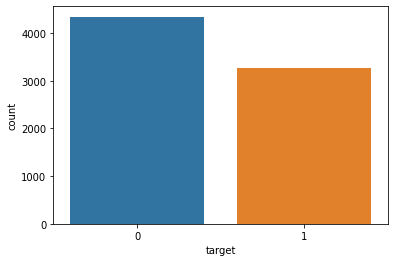

In [12]:
sns.countplot(x='target', data=train)

Text preprocessing

In [57]:
stop_words = set(stopwords.words('english'))

patterns = {
    'url'   : re.compile(r'https?://\S+|www\.\S+'),
    'html'  : re.compile(r'<.*?>'),
    'emoji' : re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE),
}

def remove_html(text):
    return patterns['html'].sub(r' ', text)

def delete_digits(text):
    return re.sub(r'\d+', ' ', text)

def delete_short_words(text, n=2):
    return ' '.join([word for word in text.split() if len(word) > n])

def delete_stop_words(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

def special_characters(tweet): 
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)  
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"donå«t", "do not", tweet)
    tweet = re.sub(r"didn`t", "did not", tweet)
    tweet = re.sub(r"i\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"i\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"i\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let us", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"that\x89Ûªs", "that is", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"here\x89Ûªs", "here is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"you\x89Ûªre", "you are", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"You\x89Ûªve", "You have", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"You\x89Ûªll", "You will", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)  
    tweet = re.sub(r"Ì©", "", tweet)
    
    # Character entity references
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    return tweet

# Removes non-ASCII characters
def remove_nonASCII(tweet):
    tweet = ''.join([x for x in tweet if x in string.printable])
    return tweet

def expand_contractions(tweet):
    
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"i'M", "I am", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"you'd", "you would", tweet)
    tweet = re.sub(r"You'd", "You would", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"You've", "You have", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"You'll", "You will", tweet)  
    tweet = re.sub(r"y'know", "you know", tweet)  
    tweet = re.sub(r"Y'know", "You know", tweet)  
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"We've", "We have", tweet) 
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"We'd", "We would", tweet)
    tweet = re.sub(r"WE'VE", "We have", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"We'll", "We will", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"They'd", "They would", tweet)  
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"They've", "They have", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"They'll", "They will", tweet)
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"He'll", "He will", tweet)
    tweet = re.sub(r"she's", "she is", tweet)
    tweet = re.sub(r"She's", "She is", tweet)
    tweet = re.sub(r"she'll", "she will", tweet)
    tweet = re.sub(r"She'll", "She will", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"It'll", "It will", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"Isn't", "Is not", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"Who's", "Who is", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"here's", "here is", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Where's", "Where is", tweet)  
    tweet = re.sub(r"wHeRE's", "where is", tweet)  
    tweet = re.sub(r"how's", "how is", tweet)  
    tweet = re.sub(r"How's", "How is", tweet)  
    tweet = re.sub(r"how're", "how are", tweet)  
    tweet = re.sub(r"How're", "How are", tweet) 
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"DON'T", "Do not", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"DIDN'T", "Did not", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    
    return tweet

def specific_corrections(tweet):
    
    '''Typos, slang and informal abbreviations'''
    
    tweet = re.sub(r"b/c", "because", tweet)
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/out", "without", tweet)
    tweet = re.sub(r"w/o", "without", tweet)
    tweet = re.sub(r"w/", "with ", tweet)   
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"c/o", "care of", tweet)
    tweet = re.sub(r"p/u", "pick up", tweet)
    tweet = re.sub(r"\n", " ", tweet)
   
    # Typos
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"wrld", "world", tweet)   
    tweet = re.sub(r"shld", "should", tweet)    
    tweet = re.sub(r"thruuu", "through", tweet)
    tweet = re.sub(r"probaly", "probably", tweet)
    tweet = re.sub(r"whatevs", "whatever", tweet)
    tweet = re.sub(r"colomr", "colour", tweet)
    tweet = re.sub(r"pileq", "pile", tweet)
    tweet = re.sub(r"firefightr", "firefighter", tweet)
    tweet = re.sub(r"LAIGHIGN", "laughing", tweet)
    tweet = re.sub(r"EXCLUSIV", "Exclusive", tweet) 
    tweet = re.sub(r"belo-ooow", "below", tweet)  
    tweet = re.sub(r"who-ooo-ole", "whole", tweet)  
    tweet = re.sub(r"brother-n-law", "father-in-law", tweet)  
    tweet = re.sub(r"referencereference", "reference", tweet)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park DPS", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"US govt", "USA government", tweet)  
    tweet = re.sub(r"WAwildfire", "WA Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"idkidk", "idk idk", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
    
    return tweet

def clean_others(tweet):  
    
    tweet = re.sub(r"2007he", "2007 he", tweet)  
    tweet = re.sub(r"Hwy27", "Hwy 27", tweet) 
    tweet = re.sub(r"jokethey", "joke they", tweet)  
    tweet = re.sub(r"40%money", "40% money", tweet)  
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"wannabe", "wanna be", tweet) 
    tweet = re.sub(r"dadwho", "dad who", tweet)  
    tweet = re.sub(r"fundwhen", "fund when", tweet)
    tweet = re.sub(r"next chp", "next chapter", tweet)
    tweet = re.sub(r"UR sons", "your sons", tweet)  
    tweet = re.sub(r"Yr voice ws", "Your voice was", tweet) 
    tweet = re.sub(r"U're not", "You are not", tweet)  
    tweet = re.sub(r"u'd win", "you had win", tweet)  
    tweet = re.sub(r"Jus Kame", "Just came", tweet)  
    tweet = re.sub(r"b4federal", "B-4, Federal", tweet) 
    tweet = re.sub(r"ppor child", "poor child", tweet)  
    tweet = re.sub(r"stand ogt", "stand out", tweet)
    tweet = re.sub(r"stand oup", "stand out", tweet) 
    tweet = re.sub(r"IS claims", "ISIS claims", tweet)
    tweet = re.sub(r"2slow2report", "too slow to report", tweet)
    tweet = re.sub(r"@ft", "@Financial Times", tweet)
    tweet = re.sub(r"50ft", "50 ft", tweet)
    tweet = re.sub(r"Ft ABH Shadow", "featuring ABH Shadow", tweet)
    tweet = re.sub(r"Since1970the", "Since 1970 the", tweet) 
    tweet = re.sub(r"whats cracking cuz", "what is cracking cause", tweet) 
    tweet = re.sub(r"mentally ill", "mental illness", tweet)
    tweet = re.sub(r"RIPRIPRIP", "RIP RIP RIP", tweet)
    tweet = re.sub(r"RIPROSS", "RIP ROSS", tweet)  
    tweet = re.sub(r"ABQ NM", "Albuquerque New Mexico", tweet)
    tweet = re.sub(r"#BC", "#British Columbia", tweet)
    tweet = re.sub(r"in BC", "in British Columbia", tweet)
    tweet = re.sub(r"BC DROUGHT", "British Columbia Drought", tweet)
    tweet = re.sub(r"in OK", "in Oklahoma", tweet)
    tweet = re.sub(r"City OK", "City Oklahoma", tweet)
    tweet = re.sub(r"Hinton OK", "Hinton Oklahoma", tweet)
    tweet = re.sub(r"Guthrie OK", "Guthrie Oklahoma", tweet)
    tweet = re.sub(r"Choctaw OK", "Choctaw Oklahoma", tweet)
    tweet = re.sub(r"Oklahoma-OK", "Oklahoma City", tweet)
    tweet = re.sub(r"Oklahoma [OK]", "Oklahoma City", tweet)
    tweet = re.sub(r"JADE FL", "JADE Florida", tweet) 
    tweet = re.sub(r"Jacksonville FL", "Jacksonville Florida", tweet)
    tweet = re.sub(r"Saint Petersburg FL", "Saint Petersburg Florida", tweet)
    tweet = re.sub(r"Wahpeton ND", "Wahpeton, North Dakota", tweet)
    tweet = re.sub(r"Northern Marians", "Northern Mariana Islands", tweet)
    tweet = re.sub(r"Northern Ma", "Northern Mariana Islands", tweet)
    
    # Abbreviation point
    tweet = re.sub(r"Dr\.", "Doctor", tweet)
    tweet = re.sub(r"f\. M\.O\.P\.", "featuring Mash Out Posse", tweet)
    tweet = re.sub(r"M\.O\.P\.", "Mash Out Posse", tweet)
    tweet = re.sub(r"M\.O\.P", "Mash Out Posse", tweet)
    tweet = re.sub(r"P\.O\.P\.E\.", "Pope", tweet)
    tweet = re.sub(r"S\.O\.S\.", "SOS", tweet)
    tweet = re.sub(r"s\.o\.s\.", "SOS", tweet)  
    tweet = re.sub(r"Fire Co\.", "Fire Company", tweet)
    tweet = re.sub(r"Holt and Co\.", "Holt and Company", tweet)
    tweet = re.sub(r"roofing co\.", "roofing company", tweet)
    tweet = re.sub(r"Costa Co\.", "Costa County", tweet)
    tweet = re.sub(r"York Co\.", "York County", tweet)
    tweet = re.sub(r"Fairfax Co\.", "Fairfax County", tweet)
    tweet = re.sub(r"I\.S\.I\.S\.", "ISIS", tweet)
    tweet = re.sub(r"U\.N\.", "United Nations", tweet)
    tweet = re.sub(r"U\.S\.", "United States", tweet)
    tweet = re.sub(r"U\.S", "United States", tweet)
    tweet = re.sub(r"U\.s\.", "United States", tweet)
    tweet = re.sub(r"U\.s", "United States", tweet)
    tweet = re.sub(r"U-S\.", "United States", tweet)
    tweet = re.sub(r"U\.S National", "United States National", tweet)
    tweet = re.sub(r"LANCASTER N\.H\.", "Lancaster New Hampshire", tweet)
    tweet = re.sub(r"Manchester N\.H\.", "Manchester New Hampshire", tweet)
   
    # Normalization
    tweet = re.sub(r"\:33333", "smile", tweet)    # :33333
    tweet = re.sub(r"\:\)\)\)\)", "smile", tweet) # :))))
    tweet = re.sub(r"\:\)\)\)", "smile", tweet) # :)))
    tweet = re.sub(r"\:\)\)", "smile", tweet)   # :))
    tweet = re.sub(r"\:-\)",  "smile", tweet)   # :-)
    tweet = re.sub(r"\;-\)",  "smile", tweet)   # ;-)
    tweet = re.sub(r"3\-D", "smile", tweet)  # 3-D
    tweet = re.sub(r"\:O", "smile", tweet)   # :O
    tweet = re.sub(r"\:D", "smile", tweet)   # :D
    tweet = re.sub(r"\:P", "smile", tweet)   # :P
    tweet = re.sub(r"\:p", "smile", tweet)   # :p
    tweet = re.sub(r"\;\)", "smile", tweet)  # ;)
    tweet = re.sub(r"\:\)", "smile", tweet)  # :)
    tweet = re.sub(r"\=\)", "smile", tweet)  # =)
    tweet = re.sub(r"\^\^", "smile", tweet)  # ^^
    tweet = re.sub(r"\:-\(", "sad", tweet)   # :-(
    tweet = re.sub(r"\:\(", "sad", tweet)    # :(
    tweet = re.sub(r"\=\(", "sad", tweet)    # =(
    tweet = re.sub(r"\-\_\_\-", "", tweet)   # -__-
    tweet = re.sub(r"\.\_\.", "", tweet)     # ._.
    tweet = re.sub(r"T\_T", "", tweet)       # T_T
    
    return tweet

# Remove unwanted words
def remove_non_alnum(tweet):
    punctuation = re.compile('[^A-Za-z0-9]+')
    return punctuation.sub(r' ',tweet)

# Remove punctuations.
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Remove leading, trailing, and extra spaces
def remove_extra_spaces(text):
    text = re.sub('\s+', ' ', text).strip() 
    return text

# Normalization
abbreviations = {
    
    "i.e":"that is", "mofo":"mother fucker", "til":"till",
    "ft.":"featuring", "mf":"mother fucker", "bout":"about",
    "ft":"featuring", "mfs":"mother fucker", "nd":"and", 
    "feat.":"featuring", "ltd":"limited", "nvr":"never",
    "feat":"featuring", "pls":"please", "ppl":"people",
    "tbs":"tablespoons", "tho":"though", "fav":"favorite",
    "bc":"because", "cuz":"because", "bcuz":"because",
    "btwn":"between", "fwy":"Freeway", "hwy":"Highway",
    "diff":"different", "appx":"approximately", 
    "im":"I am", "ive":"I have", "uve":"you have", 
    "youd":"you had", "hadnt":"had not", "isnt":"is not",
    "dont":"do not", "didnt":"did not", "cant":"cannot",
    "urself":"yourself", "wont":"would not", 
    "heres":"Here is", "lets":"Let us", "2day":"today", 
    "s2g":"swear to god", "be4":"before", "b4":"before", 
    "4the":"for the", "1st":"first",
   
    # location
    "okwx":"Oklahoma Weather", "arwx":"Arkansas Weather",    
    "gawx":"Georgia Weather", "cawx":"California Weather",
    "tnwx":"Tennessee Weather", "azwx":"Arizona Weather",  
    "alwx":"Alabama Weather", "scwx":"South Carolina Weather",
    "isis":"Islamic State", "okc":"Oklahoma","oun":"Oklahoma",
    "isil":"Islamic State", "suruc":"Urfa", "pdx":"Portland", 
    "nm":"New Mexico", "newyork":"New York", "alska":"Alaska",
    "nh":"New Hampshire", "nyc":"New York City",
    "cnmi":"Northern Mariana Islands", "calif":"California",
    "sarabia":"Saudi Arabia", "saudiarabia":"Saudi Arabia", 
    "mh370":"Malaysia Airlines Flight 370", 
    
    # units
    "12hr":"12 hr","16yr":"16 year", "hrs":"hour","hr":"hour",
    "19yrs":"19 year", "yrs":"year", "min":"minute", 
    "20yrs":"20 year", "yr":"year", "mins":"minute", 
    
    # Typos
    "tren":"trend", "kno":"know", "swea":"swear", "stil":"still",
    "fab":"fabulous", "srsly":"seriously", "epicente":"epicenter", 
    "jumpin":"jumping", "burnin":"burning", "throwin":"throwing",
    "killin":"killing", "nothin":"nothing", "thinkin":"thinking",  
    "tryin":"trying", "lookg":"looking", "fforecast":"Forecast",
    "comin":"Coming", "newss":"news", "memez":"meme", "oli":"oil",
}

def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

def clean_text(text):
    for pattern in patterns.values():
        text = pattern.sub(r' ', text)
    
    text = special_characters(text)
    text = remove_nonASCII(text)
    text = expand_contractions(text)
    text = specific_corrections(text)
    text = remove_html(text)
    text = clean_others(text)
    text = convert_abbrev_in_text(text)
    text = remove_punct(text)
    text = remove_non_alnum(text)
    text = delete_stop_words(text)
    text = delete_digits(text)
    text = delete_short_words(text)
    text = remove_extra_spaces(text)
    return text.lower().strip()

train['clean_text'] = train.text.apply(clean_text)
test['clean_text']  = test.text.apply(clean_text)

Apply lemmatization and stem

In [75]:
def lemmatize(text):
    return ' '.join([nltk.stem.WordNetLemmatizer().lemmatize(w) for w in text.split()])

def stem(text):
    return ' '.join(nltk.stem.PorterStemmer().stem(w) for w in text.split())


train['tokenized_text'] = train['clean_text'].apply(lemmatize).apply(stem).apply(str.strip)
test['tokenized_text']  = test['clean_text'].apply(lemmatize).apply(stem).apply(str.strip)

TF-IDF vectorizer

In [76]:
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1, 1))
tfidf.fit(train['tokenized_text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

Models for testing

In [152]:
def get_model(model_name, iterations=100_000):
    models = {
        'bayes'   :  MultinomialNB(),

        'log_reg' :  LogisticRegression(
            max_iter = iterations,
            solver = 'sag',
            fit_intercept = False,
            penalty = 'l2',
            dual = False,
            verbose = 0),

        'svc' : SVC(
            C=2,
            tol=1e-4,
        )
    }

    return models[model_name]

In [153]:
def fold(X, tfidf_vectorizer, model_name='bayes', iterations=100_000, k=5):
    y = X.target
    aucs, f1s, models = [], [], []
    for train_idx, test_idx in KFold(k, shuffle=True).split(X):
        X_train, X__test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y__test = y.iloc[train_idx], y.iloc[test_idx]

        model = get_model(model_name)

        train_vectors = tfidf_vectorizer.transform(X_train['tokenized_text'])
        test__vectors = tfidf_vectorizer.transform(X__test['tokenized_text'])

        model.fit(train_vectors, y_train)

        y_score = model.predict(test__vectors)

        auc = roc_auc_score(y__test, y_score)
        f1  = f1_score(y__test, y_score)

        aucs.append(auc)
        f1s.append(f1)
        models.append(model)
        print("""
ROC AUC: {}
F1     : {}
""".format(auc, f1))
        
    print("""


Mean ROC AUC: {}
Mean F1     : {}
""".format(np.mean(aucs), np.mean(f1s)))
    
    return models


models = fold(train, tfidf, model_name='svc', k=8, iterations=500_000)    


ROC AUC: 0.77553059864852
F1     : 0.7280334728033473


ROC AUC: 0.7967135476463835
F1     : 0.7608982826948482


ROC AUC: 0.7765007389704726
F1     : 0.7319727891156463


ROC AUC: 0.8019927536231883
F1     : 0.7639836289222374


ROC AUC: 0.7537364553493586
F1     : 0.7061923583662714


ROC AUC: 0.7722249408694235
F1     : 0.726027397260274


ROC AUC: 0.7893024815560027
F1     : 0.7506631299734748


ROC AUC: 0.7973476999585578
F1     : 0.7525325615050652




Mean ROC AUC: 0.7829186520777384
Mean F1     : 0.7400379525801456



TF-IDF transformation for train and test

In [154]:
test__vectors = tfidf.transform(test ['tokenized_text'])
train_vectors = tfidf.transform(train['tokenized_text'])

Kaggle submission

In [155]:
model = get_model('svc', iterations=500_000)
model.fit(train_vectors, train.target)
y_scores = model.predict(test__vectors)

In [156]:
kaggle_frame = pd.DataFrame({ 'id' : test.id, 'target' : y_scores })
kaggle_frame.target.value_counts()

0    2094
1    1169
Name: target, dtype: int64

In [157]:
kaggle_frame.to_csv('submission.csv', index=False)